# 模型选择、欠拟合和过拟合
通过多项式拟合来交互地探索这些概念

In [29]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

# 1 dataset
使用以下三阶多项式来生成训练和测试数据的标签
y=5+1.2x−3.4x^/2!+5.6x^3/3!+ϵ where ϵ∼N(0,0.1^2)

In [30]:
max_degree = 10
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)#20x1
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])#0-3初始化，多项式的系数，后面剩余的16项系数都是noise

#normal distribution
features = np.random.normal(size=(n_train + n_test, 1))#200x1
#shuffle the features
np.random.shuffle(features)
#多项式200x1  1x20 
#实现x的幂次运算power(number,power指数)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    #实现/阶乘
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
#加上b
labels += np.random.normal(scale=0.1, size=labels.shape)

前两个样本

In [31]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.9653],
         [ 1.9694]]),
 tensor([[ 1.0000e+00, -9.6535e-01,  4.6595e-01, -1.4993e-01,  3.6185e-02,
          -6.9862e-03,  1.1240e-03, -1.5501e-04,  1.8705e-05, -2.0063e-06],
         [ 1.0000e+00,  1.9694e+00,  1.9393e+00,  1.2731e+00,  6.2679e-01,
           2.4688e-01,  8.1033e-02,  2.2798e-02,  5.6123e-03,  1.2281e-03]]),
 tensor([1.4618, 7.9290]))

# 2 Loss
实现一个函数来评估模型在给定数据集上的损失

In [32]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

# 3 Training

In [33]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    #自己计算？
    input_shape = train_features.shape[-1]

    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

# 4 拟合
## 4.1 正态
y=5+1.2x−3.4x^/2!+5.6x^3/3!
Gap小

weight: [[ 5.0176573  1.2075949 -3.4067338  5.5599794]]


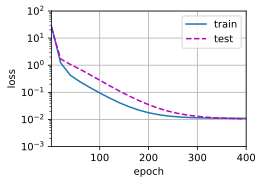

In [34]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

# 4.2 undefitting
模型简单，只用两项

weight: [[3.3319638 4.3619466]]


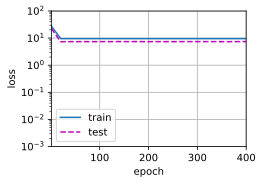

In [35]:
# 5 + 1.2x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

# 4.3 Overfitting
高阶多项式函数拟合(过拟合):
10次多项式，test和train之间的gap很大，后面loss上升的地方可能把noise学进去了，造成了过拟合

weight: [[ 5.006051    1.2692938  -3.3573122   5.157508   -0.07714308  1.3631889
  -0.1146526   0.08410487  0.17711312  0.25198382]]


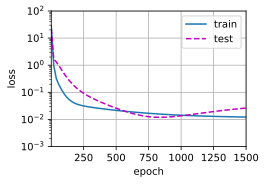

In [36]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)